# Importing Libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    username="root",
    password="$Hustlebro123",
    database="ecommerce"
)
cur = db.cursor()


# Loading Dataset from csv

In [12]:
import os
import pandas as pd

# Set your folder path
folder_path = '/Users/utkarshsharma/Desktop/E-Commerce'  # Make sure it's relative or full path

# List of expected files and corresponding variable names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geo'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Create a dictionary to hold dataframes
dfs = {}

# Load each CSV into the dictionary
for file_name, df_name in csv_files:
    full_path = os.path.join(folder_path, file_name)
    
    # Auto-parse dates for orders only
    if file_name == 'orders.csv':
        dfs[df_name] = pd.read_csv(full_path, parse_dates=['order_purchase_timestamp'])
    else:
        dfs[df_name] = pd.read_csv(full_path)

# Unpack variables for easier access
customers = dfs['customers']
orders = dfs['orders']
sellers = dfs['sellers']
products = dfs['products']
geo = dfs['geo']
payments = dfs['payments']
order_items = dfs['order_items']


# Dataset Overview

In [13]:
for name, df in dfs.items():
    print(f"{name}: {df.shape}")


customers: (99441, 5)
orders: (99441, 8)
sellers: (3095, 4)
products: (32951, 9)
geo: (1000163, 5)
payments: (103886, 5)
order_items: (112650, 7)


In [14]:
# EDA Summary: Shapes, Nulls, Types
for name, df in dfs.items():
    print(f"\n{name.upper()} - Shape: {df.shape}")
    print(df.dtypes)
    print(df.isnull().sum())
    print("="*50)



CUSTOMERS - Shape: (99441, 5)
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

ORDERS - Shape: (99441, 8)
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
o

#  Data Cleaning: Orders and Payments

In [15]:
# Keep only delivered orders and valid timestamps
orders_clean = orders[orders['order_status'] == 'delivered'].copy()

# Remove rows with null timestamps or customer_id
orders_clean.dropna(subset=['order_purchase_timestamp', 'customer_id'], inplace=True)

# Remove duplicate orders if any
orders_clean.drop_duplicates(subset=['order_id'], inplace=True)

# Clean payments: remove rows with nulls in payment_value or order_id
payments_clean = payments.dropna(subset=['payment_value', 'order_id'])

# Remove duplicate payment records
payments_clean.drop_duplicates(subset=['order_id', 'payment_value'], inplace=True)

# Remove zero payments
payments_clean = payments_clean[payments_clean['payment_value'] > 0]

# Remove top 1% high-value outliers
payments_clean = payments_clean[payments_clean['payment_value'] < payments_clean['payment_value'].quantile(0.99)]



# Merging Orders and Payments Data

In [16]:
# Merge orders and payments
rfm_data = pd.merge(
    orders_clean[['order_id', 'customer_id', 'order_purchase_timestamp']],
    payments_clean[['order_id', 'payment_value']],
    on='order_id',
    how='inner'
)

# Drop full duplicates (row-level)
rfm_data.drop_duplicates(inplace=True)

# Final sanity check
print("rfm_data shape:", rfm_data.shape)
print("Null values:\n", rfm_data.isnull().sum())


rfm_data shape: (99203, 4)
Null values:
 order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               0
dtype: int64


# Calculating RFM Metrics

- **Recency**: Days since last purchase.
- **Frequency**: Number of orders.
- **Monetary**: Total spend.

In [17]:
latest_date = rfm_data['order_purchase_timestamp'].max()

rfm_temp = rfm_data.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

rfm_temp.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


# RFM Distribution and Correlation Analysis

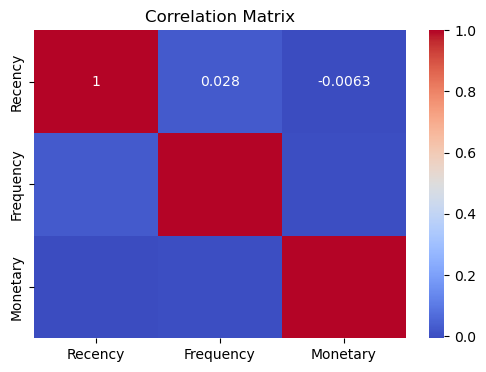

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


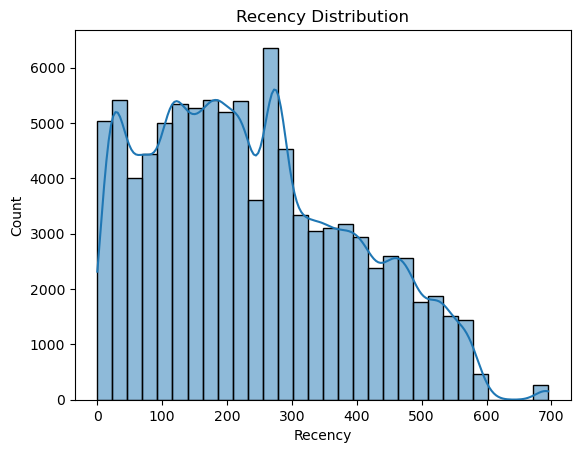

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


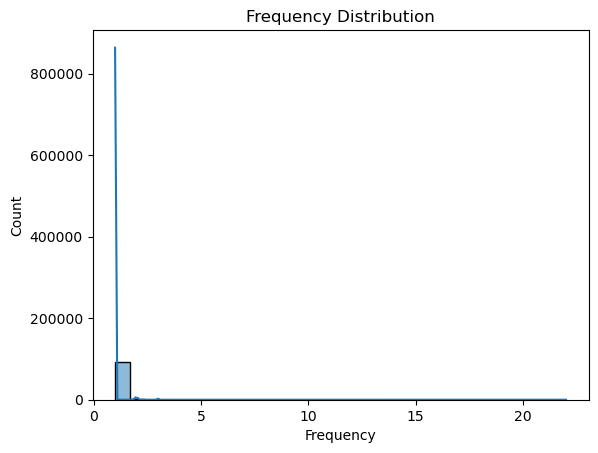

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


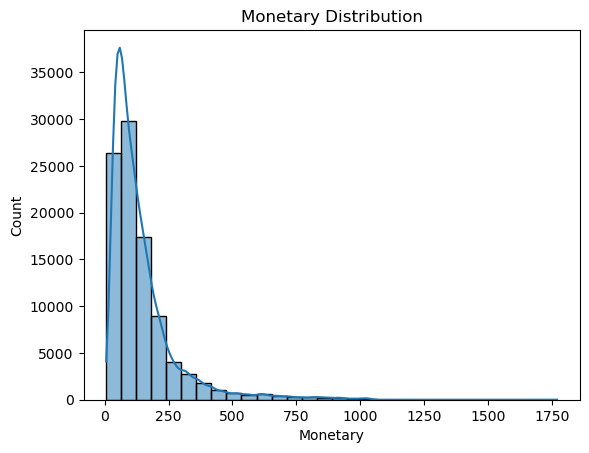

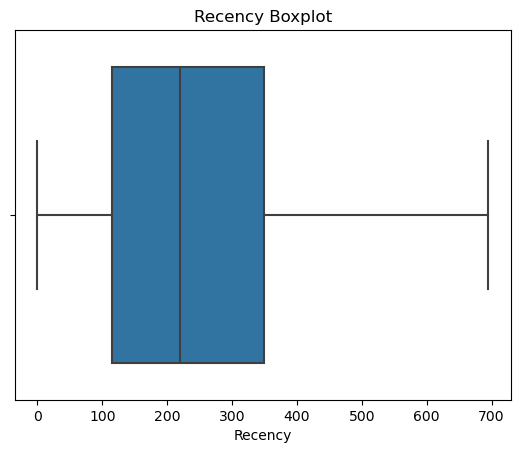

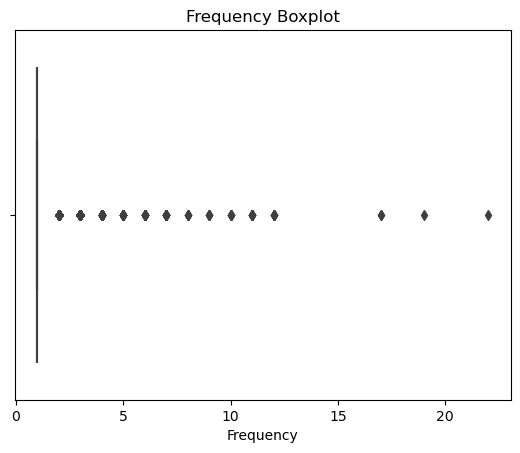

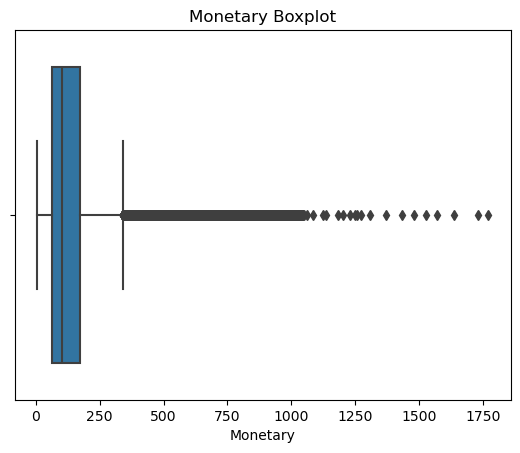

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(rfm_temp[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Histograms
for col in ['Recency', 'Frequency', 'Monetary']:
    sns.histplot(rfm_temp[col], bins=30, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

# Boxplots
for col in ['Recency', 'Frequency', 'Monetary']:
    sns.boxplot(x=rfm_temp[col])
    plt.title(f"{col} Boxplot")
    plt.show()


# RFM

In [20]:
# Get the latest date of purchase
latest_date = rfm_data['order_purchase_timestamp'].max()
print("Latest transaction date:", latest_date)

# Group by customer to calculate RFM
rfm_temp = rfm_data.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,  # Recency
    'order_id': 'count',        # Frequency
    'payment_value': 'sum'      # Monetary
}).reset_index()

# Rename columns
rfm_temp.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview
print(rfm_temp.head())


Latest transaction date: 2018-08-29 15:00:37
                         CustomerID  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74
1  000161a058600d5901f007fab4c27140      409          1     67.41
2  0001fd6190edaaf884bcaf3d49edf079      547          1    195.42
3  0002414f95344307404f0ace7a26f1d5      378          1    179.35
4  000379cdec625522490c315e70c7a9fb      149          1    107.01


# RFM Segmentation

Segment customers based on quantiles of R, F, M scores. Combine into RFM score.

In [55]:
rfm_temp['R'] = pd.qcut(rfm_temp['Recency'], 4, labels=[4, 3, 2, 1])
rfm_temp['F'] = pd.qcut(rfm_temp['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm_temp['M'] = pd.qcut(rfm_temp['Monetary'], 4, labels=[1, 2, 3, 4])
rfm_temp['RFM_Score'] = rfm_temp[['R', 'F', 'M']].sum(axis=1).astype(int)
rfm_temp.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,00012a2ce6f8dcda20d059ce98491703,287,1,114.74,2,1,3,6
1,000161a058600d5901f007fab4c27140,409,1,67.41,1,1,2,4
2,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,1,1,4,6
3,0002414f95344307404f0ace7a26f1d5,378,1,179.35,1,1,4,6
4,000379cdec625522490c315e70c7a9fb,149,1,107.01,3,1,3,7


| Metric           | Conclusion                                                                      |
| ---------------- | ------------------------------------------------------------------------------- |
| **Recency**      | Many customers are inactive — last purchase over 6–12 months ago                |
| **Frequency**    | Most users order only once — customer stickiness is very low                    |
| **Monetary**     | Majority of users spend under ₹300 — with a small top-spending tail             |
| **Segmentation** | RFM scores will help identify VIPs, loyal customers, and churn risks            |


-Distribution Insights
Most customers spend between ₹50–₹300
A few customers spend ₹1000+, but very rare
Insight: The platform has a small high-value customer segment — focus retention efforts here.

-Frequency Distribution 
~85–90% of customers ordered only once
Very few customers ordered more than 3 times
Insight: Low customer retention — the majority are one-time buyers

-This is a critical business issue. Consider loyalty programs, re-engagement campaigns, or bundle offers.



# RFM Score Distribution

See how your customers are spread across the overall RFM scores (from 3 to 12).

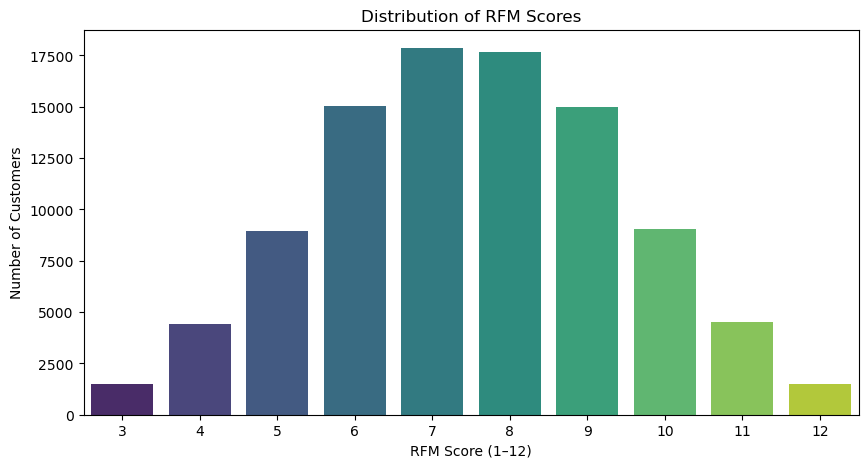

In [59]:
plt.figure(figsize=(10, 5))
sns.countplot(x='RFM_Score', data=rfm_temp, palette='viridis')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score (1–12)')
plt.ylabel('Number of Customers')
plt.show()


# Heatmap of RFM Segments (R x F)

This shows how Recency and Frequency combine across customers — identifying loyal vs. recent vs. slipping customers.

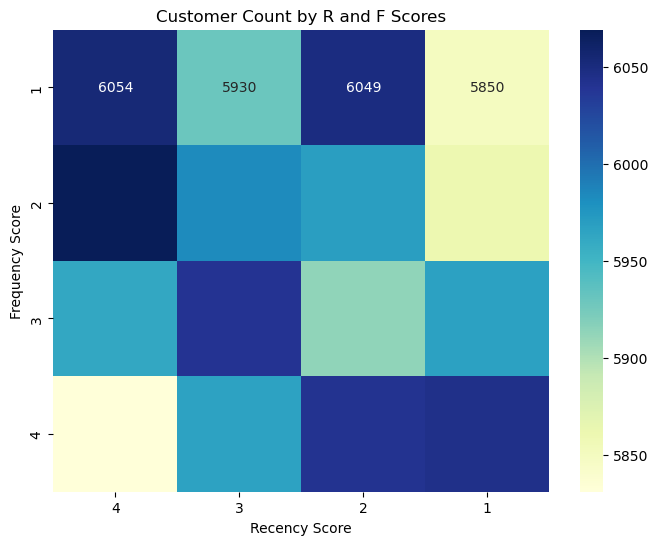

In [61]:
rfm_heatmap = rfm_temp.pivot_table(index='F', columns='R', values='CustomerID', aggfunc='count')
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Customer Count by R and F Scores")
plt.xlabel("Recency Score")
plt.ylabel("Frequency Score")
plt.show()


# Monetary vs Frequency (Color by Recency)

This 2D scatter helps visualize high spenders vs. frequent buyers, colored by recency to spot potential drop-offs.

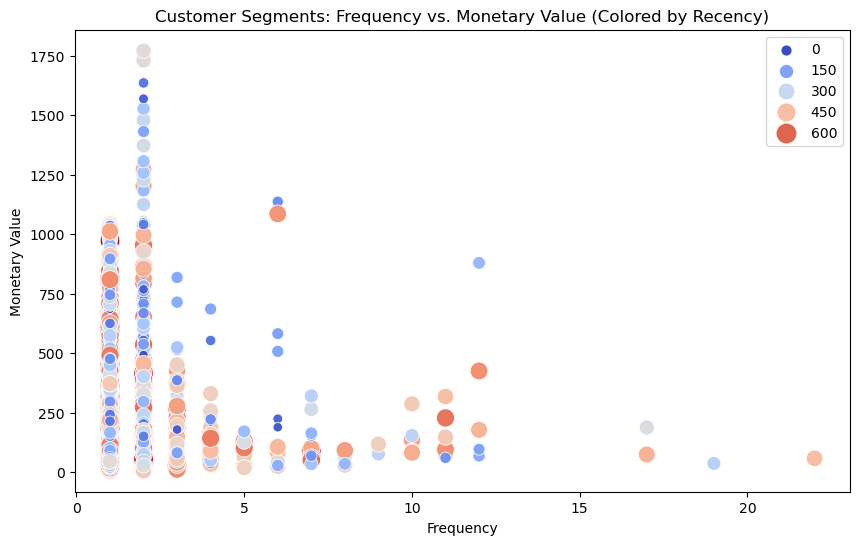

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_temp, x='Frequency', y='Monetary', hue='Recency', palette='coolwarm', size='Recency', sizes=(40, 200))
plt.title('Customer Segments: Frequency vs. Monetary Value (Colored by Recency)')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.legend()
plt.show()


 # Key Insights and Business Recommendations

- ## Customers with high `RFM_Score` (9–12): Likely champions, target for loyalty and upsell programs.
- ## Low Recency & Frequency: Might be "at risk" or inactive — re-engagement campaigns recommended.
- ## High Monetary but low Frequency: Potential for subscription-based engagement.